Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial

import warnings
warnings.filterwarnings('ignore')
AUTO = tf.data.experimental.AUTOTUNE


In [2]:
import sys

sys.path.append('c:\python312\lib\site-packages')

import cv2

In [3]:
path='A:/NLP/dog-classifier/'

In [4]:
df = pd.read_csv(path+'dog-breed-identification/labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Exploratory Data Analysis

In [5]:
df.shape

(10222, 2)

In [6]:
df['breed'].nunique()

120

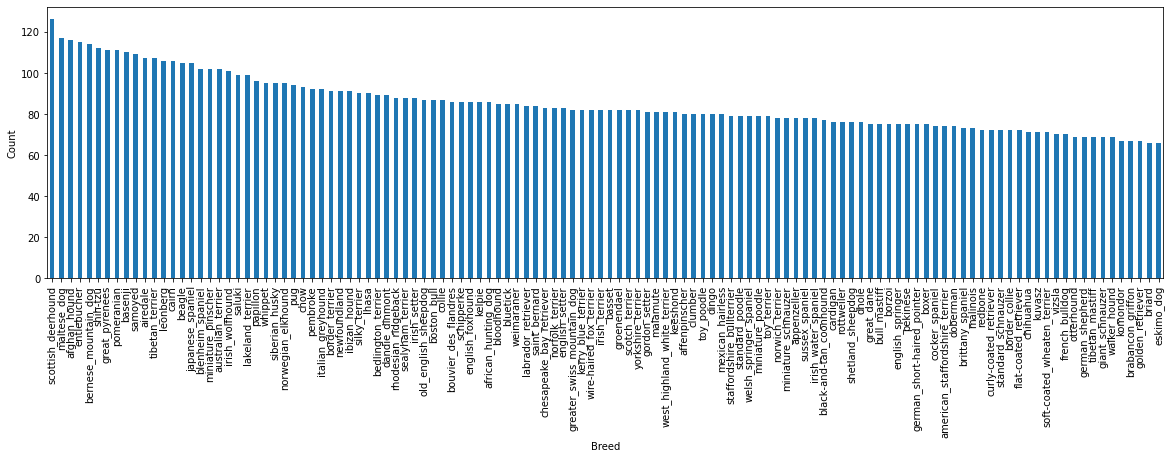

In [7]:
plt.figure(figsize=(20, 5))
df['breed'].value_counts().plot.bar()
plt.xlabel('Breed')
plt.ylabel('Count')
# plt.axis('off')
plt.show()


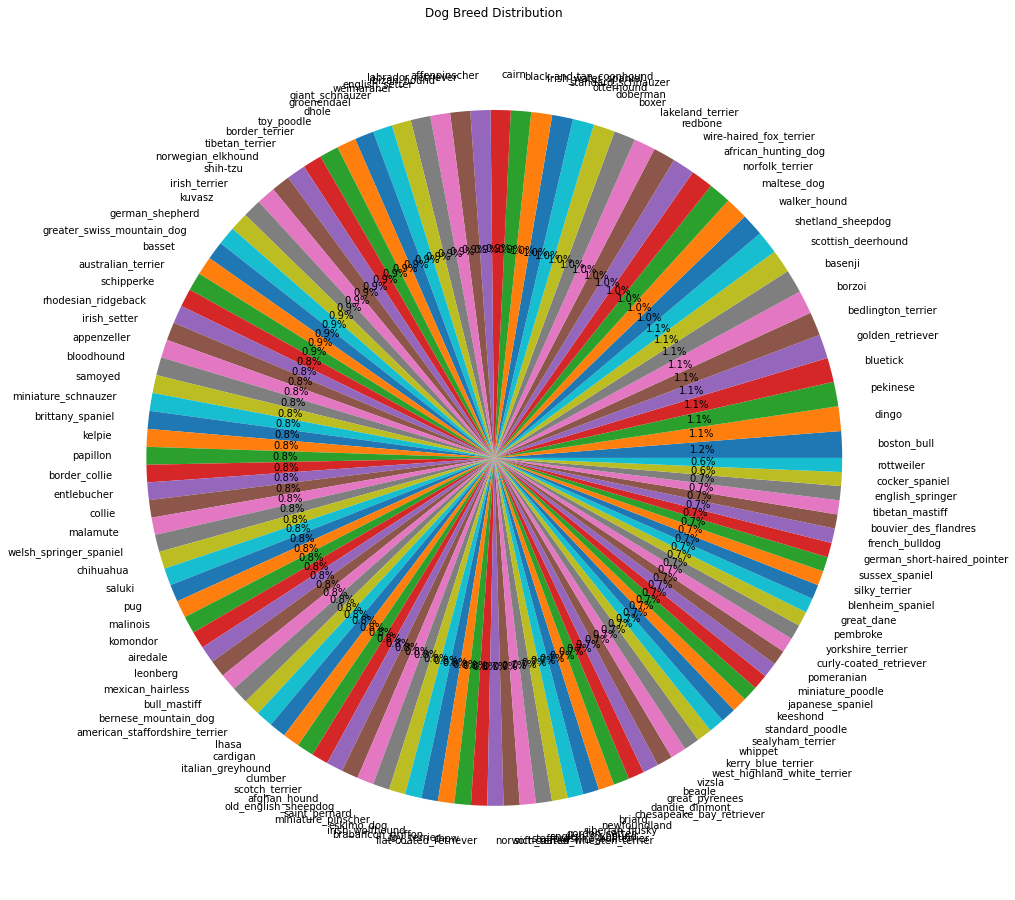

In [8]:
# Sample data (e.g., counts of dog breeds)
data = {'Breed': df['breed'].unique(),
        'Count': df['breed'].value_counts()}

t_df = pd.DataFrame(data)

# Create a pie chart
t_df.set_index('Breed')['Count'].plot(kind='pie', autopct='%1.1f%%', figsize=(16, 16))

# Display the plot
plt.title('Dog Breed Distribution')
plt.ylabel('')  # Hide the ylabel for a cleaner look
plt.show()


In [9]:
df['filepath'] = 'A:/NLP/dog-classifier/dog-breed-identification/train/' + df['id'] + '.jpg'
df.head()


,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,A:/NLP/dog-classifier/dog-breed-identification...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,A:/NLP/dog-classifier/dog-breed-identification...
2,001cdf01b096e06d78e9e5112d419397,pekinese,A:/NLP/dog-classifier/dog-breed-identification...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,A:/NLP/dog-classifier/dog-breed-identification...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,A:/NLP/dog-classifier/dog-breed-identification...


A:/NLP/dog-classifier/dog-breed-identification/train/4e475f0d2f1808216a28e2f635c17297.jpg
A:/NLP/dog-classifier/dog-breed-identification/train/c28801dd739c5070a19461bb1d6a72b0.jpg
A:/NLP/dog-classifier/dog-breed-identification/train/bd66845e2afbc4fa641eb5fde30aa294.jpg
A:/NLP/dog-classifier/dog-breed-identification/train/81d3559cfe8ae808fb3cf8b223ffb999.jpg
A:/NLP/dog-classifier/dog-breed-identification/train/d906ce11e75fd245403be6c907bf6d3b.jpg
A:/NLP/dog-classifier/dog-breed-identification/train/45f35f209231efc1baebf0729ba4e01f.jpg
A:/NLP/dog-classifier/dog-breed-identification/train/57e20e6314599cc5b16474a44511d2d5.jpg
A:/NLP/dog-classifier/dog-breed-identification/train/2e7bbac9b93c30169f2cfca57bbf1d27.jpg
A:/NLP/dog-classifier/dog-breed-identification/train/fc71c9e6334f37a9f42c00e599af8b02.jpg
A:/NLP/dog-classifier/dog-breed-identification/train/889623dfc6b119e79a931d34a1ec081b.jpg
A:/NLP/dog-classifier/dog-breed-identification/train/fe78fc42e32174c7178b572bdcf5a129.jpg
A:/NLP/dog

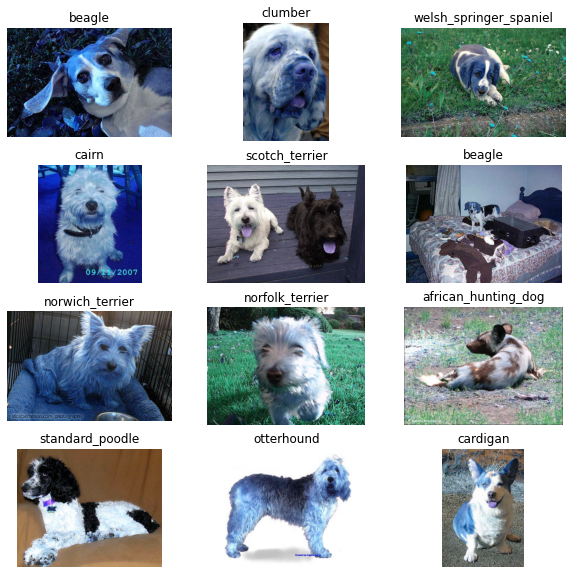

In [10]:
plt.subplots(figsize=(10, 10))
for i in range(12):
    plt.subplot(4, 3, i+1)

    # Selecting a random image
    # index from the dataframe.
    k = np.random.randint(0, len(df))
    print(df.loc[k, 'filepath'])
    img = cv2.imread(df.loc[k, 'filepath'])
    plt.imshow(img)
    plt.title(df.loc[k, 'breed'])
    plt.axis('off')
plt.show()


In [11]:
df['breed'] = LabelEncoder().fit_transform(df['breed'])
df.head()


,id,breed,filepath
0,000bec180eb18c7604dcecc8fe0dba07,19,A:/NLP/dog-classifier/dog-breed-identification...
1,001513dfcb2ffafc82cccf4d8bbaba97,37,A:/NLP/dog-classifier/dog-breed-identification...
2,001cdf01b096e06d78e9e5112d419397,85,A:/NLP/dog-classifier/dog-breed-identification...
3,00214f311d5d2247d5dfe4fe24b2303d,15,A:/NLP/dog-classifier/dog-breed-identification...
4,0021f9ceb3235effd7fcde7f7538ed62,49,A:/NLP/dog-classifier/dog-breed-identification...


Data Preparation

In [12]:
features = df['filepath']
target = df['breed']

X_train, X_val, Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.15,
                                      random_state=10)

X_train.shape, X_val.shape

((8688,), (1534,))

Applying Image Augmentation

In [13]:
import albumentations as A

transforms_train = A.Compose([
    A.VerticalFlip(p=0.2),
    A.HorizontalFlip(p=0.7),
    A.CoarseDropout(p=0.5),
    A.RandomGamma(p=0.5),
    A.RandomBrightnessContrast(p=1)
])


Building the Input Pipeline

In [14]:
def aug_fn(img):
    aug_data = transforms_train(image=img)
    aug_img = aug_data['image']

    return aug_img


@tf.function
def process_data(img, label):
    aug_img = tf.numpy_function(aug_fn,
                                [img],
                                Tout=tf.float32)

    return img, label


def decode_image(filepath, label=None):

    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [128, 128])
    img = tf.cast(img, tf.float32) / 255.0

    if label == None:
        return img

    return img, tf.one_hot(indices=label,
                           depth=120,
                           dtype=tf.float32)


In [15]:
train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(partial(process_data), num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val, Y_val))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)


Model Building Using Transfer Learning

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
    input_shape=(128, 128, 3),
    weights='imagenet',
    include_top=False
)

87910968/87910968 [==============================] - 19s 0us/step


In [17]:
len(pre_trained_model.layers)

311

In [18]:
for layer in pre_trained_model.layers: 
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7') 
# Access the output shape from the output tensor of the layer
print('last layer output shape: ', last_layer.output.shape) 
last_output = last_layer.output


last layer output shape:  (None, 6, 6, 768)


In [19]:
# Model Architecture
x = layers.Flatten()(last_output)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(120, activation='softmax')(x)

model = keras.Model(pre_trained_model.input, output)

# Model Compilation
model.compile(
    optimizer='adam',
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.AUC()]
)


In [20]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_auc') is not None and logs.get('val_auc') > 0.99:
            print('\n Validation accuracy has reached upto 90% so, stopping further training.')
            self.model.stop_training = True

es = EarlyStopping(patience=3,
                monitor='val_auc',
                restore_best_weights=True,
                mode='max')

lr = ReduceLROnPlateau(monitor='val_loss',
                    patience=2,
                    factor=0.5,
                    verbose=1)


Train the Model

In [21]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50,
                    verbose=1,
                    callbacks=[es, lr, myCallback()])


Epoch 1/50
272/272 [==============================] - 85s 293ms/step - loss: 3.7529 - auc: 0.8166 - val_loss: 2.5121 - val_auc: 0.9442 - lr: 0.0010
Epoch 2/50
272/272 [==============================] - 74s 271ms/step - loss: 2.0028 - auc: 0.9708 - val_loss: 2.3130 - val_auc: 0.9446 - lr: 0.0010
Epoch 3/50
272/272 [==============================] - 70s 258ms/step - loss: 1.0056 - auc: 0.9950 - val_loss: 2.4077 - val_auc: 0.9297 - lr: 0.0010
Epoch 4/50
272/272 [==============================] - ETA: 0s - loss: 0.3987 - auc: 0.9995
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
272/272 [==============================] - 73s 268ms/step - loss: 0.3987 - auc: 0.9995 - val_loss: 2.5417 - val_auc: 0.9130 - lr: 0.0010
Epoch 5/50
272/272 [==============================] - 71s 260ms/step - loss: 0.1318 - auc: 0.9999 - val_loss: 2.3397 - val_auc: 0.9227 - lr: 5.0000e-04


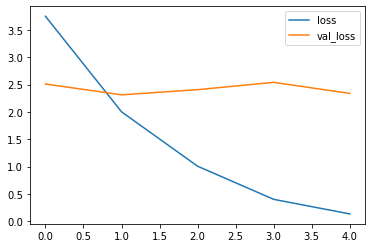

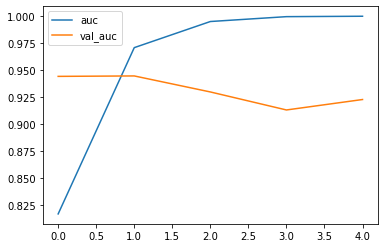

In [22]:
history_df = pd.DataFrame(history.history) 
history_df.loc[:, ['loss', 'val_loss']].plot() 
history_df.loc[:, ['auc', 'val_auc']].plot() 
plt.show()
